## Import Libs

In [219]:
import numpy as np
import pandas as pd
import csv
import os
import sys
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

In [220]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Variables

In [221]:
dataset_path = './data/gtzan'
diraudiofiles = f"{dataset_path}/genres_3sec"
features_path = f'{dataset_path}/features'
melspec_path = f'{features_path}/melspecs_3sec'
test_dir = f'{dataset_path}/test1'

In [222]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

In [223]:
ignorefiles = ['jazz.00054.wav']

In [224]:
target_size = (288, 432)
# target_size = (640,480)
batch_size = 128

## Load Pretrained Model

In [225]:
import keras.backend as K

In [226]:
def get_f1(y_true, y_pred): # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [227]:
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

In [228]:
model = tf.keras.models.load_model("results/model", custom_objects={'get_f1': get_f1})

In [229]:
import pickle

In [230]:
with open('results/history.pkl', 'rb') as f:
    hist = pickle.load(f)

In [231]:
def plot_history(hist):
    fig,ax = plt.subplots(2, 1, figsize=(8,5))
    # fig.tight_layout()

    ax[0].plot(hist['accuracy'])
    ax[0].plot(hist['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'val'], loc='upper left')

    plt.subplots_adjust(hspace = 0.4)

    ax[1].plot(hist['loss'])
    ax[1].plot(hist['val_loss'])
    plt.title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper left')

    plt.show()

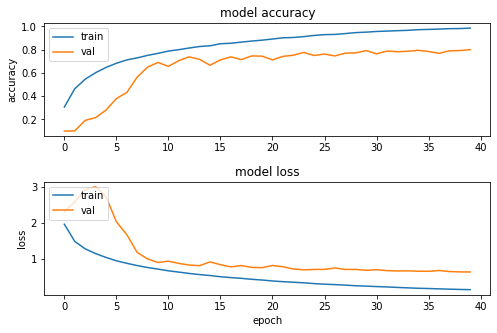

In [232]:
plot_history(hist)

## Evaluate Model

In [233]:
def predict(model, image_data, target_size, classes):
    image = image_data.resize((288,432))
    image = img_to_array(image_data)
    image = np.reshape(image,(1,*target_size,4))
    image /= 255
    prediction = model.predict(image)
    prediction = prediction.reshape((classes,))
    class_label = np.argmax(prediction)

    return class_label,prediction

In [234]:
def evaluate(path):
    image_data = load_img(path, color_mode='rgba',target_size=target_size)
    label, scores = predict(model, image_data, target_size, len(genres))
    return label

In [235]:
genres[evaluate('data/gtzan/melspecs_3sec/blues/blues.00110.png')]

'metal'

In [236]:
data = []

for path in Path(f'{dataset_path}/test').glob("**/*.png"):
    if sys.platform == 'win32':
        pathsep = '\\'
    else:
        pathsep = '/'
        
    label = str(path).split(pathsep)[-2]
    name = str(path).split(pathsep)[-1]
    
    if name in ignorefiles:
        continue

    data.append({
        # "name": name,
        "path": path,
        "label": label
    })

In [237]:
df = pd.DataFrame(data)
df.groupby("label").count()[["path"]]

,path
label,
blues,50
classical,50
country,50
disco,50
hiphop,50
jazz,39
metal,50
pop,50
reggae,50


In [238]:
scores = list(map(evaluate, df['path']))

In [239]:
y_true = df['label'].to_list()
y_pred = [genres[i] for i in scores]

In [240]:
from sklearn.metrics import classification_report

In [241]:
print(classification_report(y_true, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        50
   classical       0.78      0.78      0.78        50
     country       0.32      0.90      0.47        50
       disco       0.80      0.32      0.46        50
      hiphop       0.00      0.00      0.00        50
        jazz       0.42      0.77      0.54        39
       metal       0.35      0.98      0.51        50
         pop       0.00      0.00      0.00        50
      reggae       0.52      0.66      0.58        50
        rock       0.00      0.00      0.00        50

    accuracy                           0.43       489
   macro avg       0.32      0.44      0.33       489
weighted avg       0.32      0.43      0.33       489



E:\projects\mlproj\mlproj\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\projects\mlproj\mlproj\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\projects\mlproj\mlproj\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Predict Genres of Manually Curated Songs

In [242]:
test_dir = f'{dataset_path}/test1'
song = 'Taylor_Swift_Love_Story'
song += ' Nirvana_Smells_Like_Teen_Spirit'
song += ' Green_Day_American_Idiot'
songs = song.split()

preds = None

for song in songs:
    pred = None
    for i, filename in enumerate(os.listdir(f'{test_dir}')):
        if song not in filename:
            continue
        image_data = load_img(f'{test_dir}/{filename}',color_mode='rgba',target_size=target_size)
        class_label, prediction = predict(model, image_data, target_size, 10)
        if pred is None:
            pred = prediction
        else:
            pred = (pred + prediction)

    if preds is None:
        preds = pred / np.sum(pred)
    else:
        preds = np.vstack([preds, pred / np.sum(pred)])

In [243]:
np.sum(preds,axis=1)

array([1.0000001 , 0.99999994, 1.        ], dtype=float32)

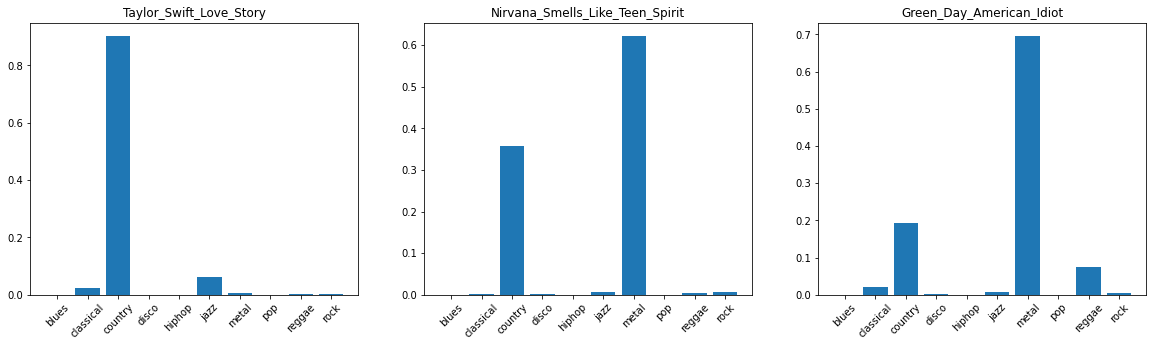

In [244]:
fig,ax = plt.subplots(1,len(songs),figsize=(20,5))

for i in range(len(songs)):
    ax[i].bar(x=genres,height=preds[i])
    ax[i].tick_params('x', labelrotation=45)
    ax[i].set_title(f'{songs[i]}')
    
plt.show()